# Network Project

*By Daniel Deutsch, Joseé Lucas Barretto, Karim Jaber and Ziyad Bekkaoui*

In [153]:
import warnings

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pytrends.request import TrendReq


In [103]:
# Filter warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Data Import

In [104]:
# Import the wikileaks dataset
df = pd.read_parquet('datasets/wikileaks.parquet')

# Import Google Trends data
pytrends = TrendReq()
pytrends.build_payload(['wikileaks'], timeframe='all')
df_trends = pytrends.interest_over_time()

# Data Processing

In [106]:
# Process the Wikileaks dataframe
df['date'] = pd.to_datetime(df['time'], unit='s')
df.rename(columns={'PriceUSD': 'price_usd', 'valueUSD': 'value_usd'}, inplace=True)
df.sort_values(by='date', inplace=True)

# Process the Google Trends dataframe
df_trends = df_trends.reset_index()
df_trends.rename(columns={'wikileaks': 'trend'}, inplace=True)

# Donations to Wikileaks Over Time

In [107]:
# List of Wikileaks addresses
wikileaks_dsts = ['1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v', '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4']

# Aggregates donations to wikileaks by day
df_agg = df[df['dst'].isin(wikileaks_dsts)].set_index('date').resample('MS')['value_usd'].aggregate(['sum', 'count']).reset_index()

# Merges aggregated results with google trends on date
df_agg = pd.merge(df_agg, df_trends, how='inner', right_on='date', left_on='date')

## Value Bitcoin Donations to Wikileaks Over Time

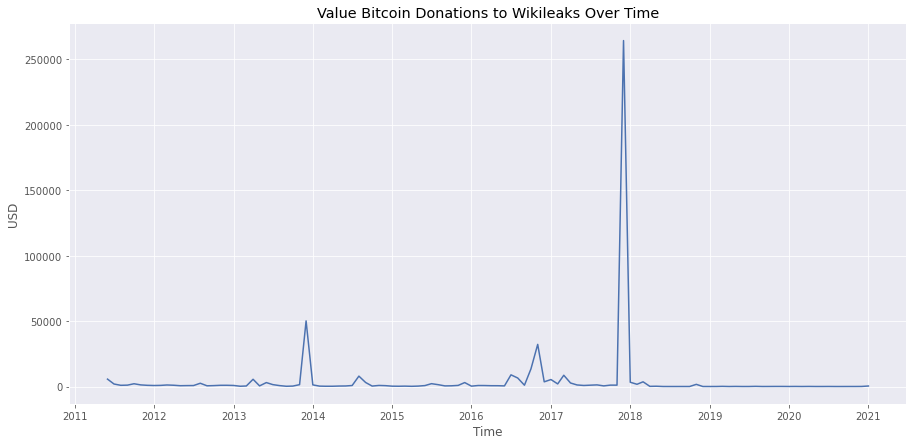

In [108]:
plt.plot(df_agg['date'], df_agg['sum'])
plt.title('Value Bitcoin Donations to Wikileaks Over Time')
plt.ylabel('USD')
plt.xlabel('Time')
plt.show()

## Number of Bitcoin Donations to Wikileaks Over Time

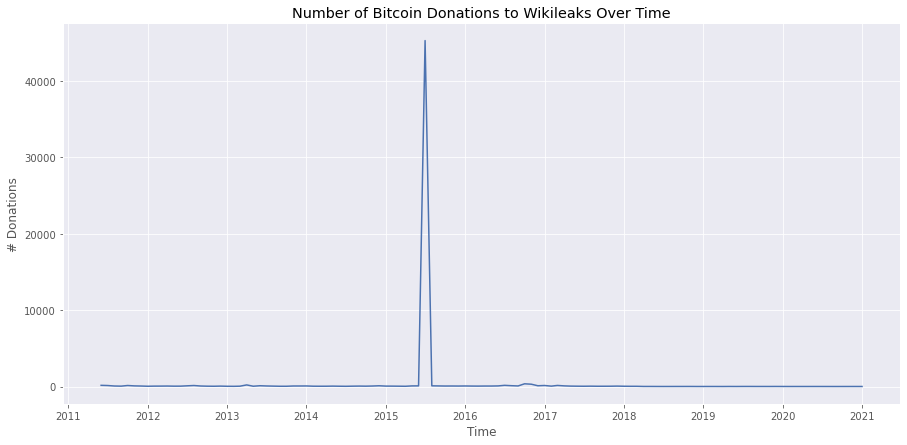

In [109]:
plt.plot(df_agg['date'], df_agg['count'])
plt.title('Number of Bitcoin Donations to Wikileaks Over Time')
plt.ylabel('# Donations')
plt.xlabel('Time')
plt.show()

## Correlation Between Number of Wikileaks Donations and Google Trends

In [123]:
# Adds the log of the aggregated values to the dataframe
df_agg['log_sum'] = np.log(df_agg['sum'])
df_agg['log_count'] = np.log(df_agg['count'])

# Shows the correlation between each column
df_agg[['sum', 'count', 'trend', 'log_sum', 'log_count']].corr()

,sum,count,trend,log_sum,log_count
sum,1.000000,-0.006099,0.036456,0.355351,0.101822
count,-0.006099,1.000000,0.001077,0.079223,0.442853
trend,0.036456,0.001077,1.000000,0.448967,0.455833
log_sum,0.355351,0.079223,0.448967,1.000000,0.781307
log_count,0.101822,0.442853,0.455833,0.781307,1.000000


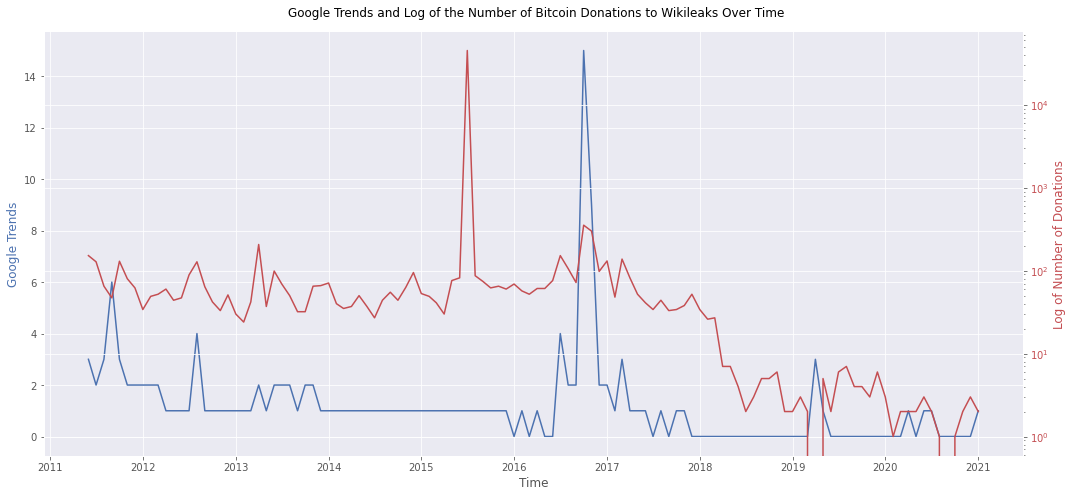

In [121]:
fig, ax1 = plt.subplots()

ax1.plot(df_agg['date'], df_agg['trend'])
ax1.tick_params(axis='y')
ax1.set_xlabel("Time")
ax1.set_ylabel("Google Trends", color='#4C72B0')

ax2 = ax1.twinx()

ax2.plot(df_agg['date'], df_agg['count'], color='#C44E52')
ax2.tick_params(axis='y', labelcolor='#C44E52')
ax2.set_ylabel('Log of Number of Donations', color='#C44E52')
ax2.set_yscale('log')

plt.suptitle("Google Trends and Log of the Number of Bitcoin Donations to Wikileaks Over Time")
plt.tight_layout()
plt.show()

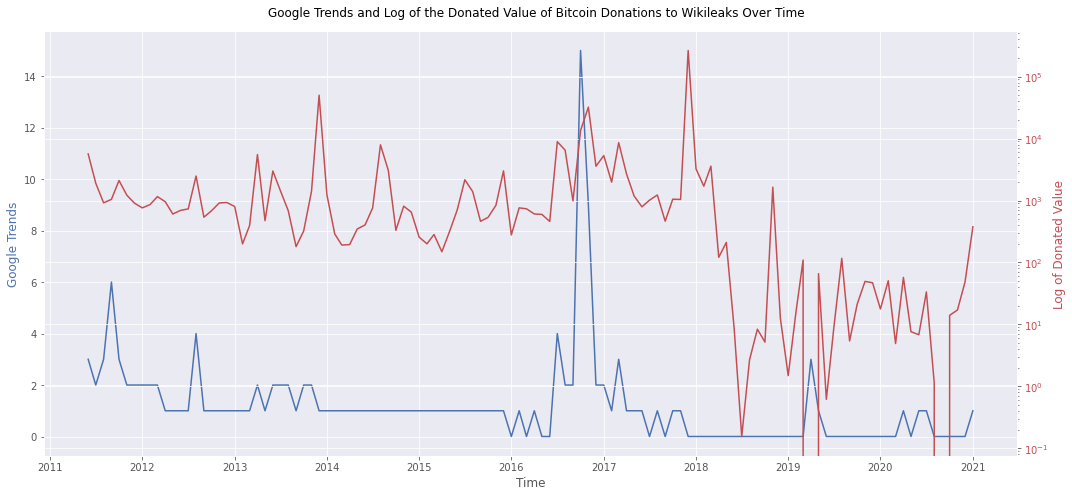

In [122]:
fig, ax1 = plt.subplots()

ax1.plot(df_agg['date'], df_agg['trend'])
ax1.tick_params(axis='y')
ax1.set_xlabel("Time")
ax1.set_ylabel("Google Trends", color='#4C72B0')

ax2 = ax1.twinx()

ax2.plot(df_agg['date'], df_agg['sum'], color='#C44E52')
ax2.tick_params(axis='y', labelcolor='#C44E52')
ax2.set_ylabel('Log of Donated Value', color='#C44E52')
ax2.set_yscale('log')

plt.suptitle("Google Trends and Log of the Donated Value of Bitcoin Donations to Wikileaks Over Time")
plt.tight_layout()
plt.show()

# Histogram Of the Value of Donations to Wikileaks

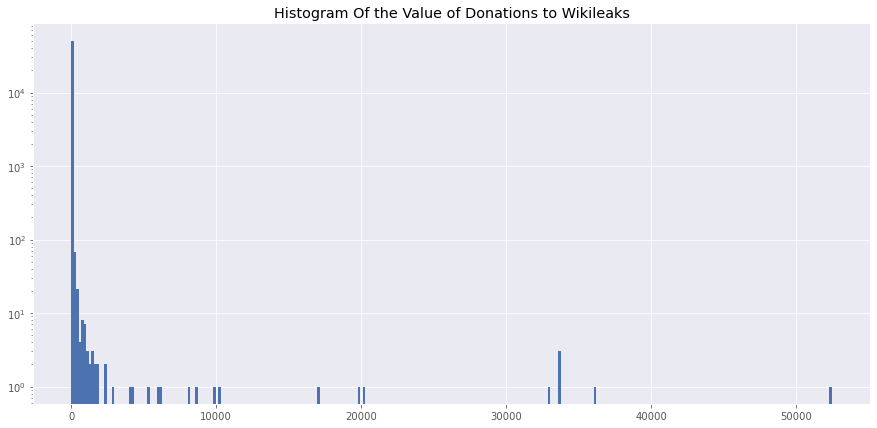

In [128]:
df[df['dst'].isin(wikileaks_dsts)]['value_usd'].hist(bins=300, log=True)
plt.title("Histogram Of the Value of Donations to Wikileaks")
plt.show()

# Comparison Histogram Of the Value of Donations to Wikileaks and from Wikileaks 

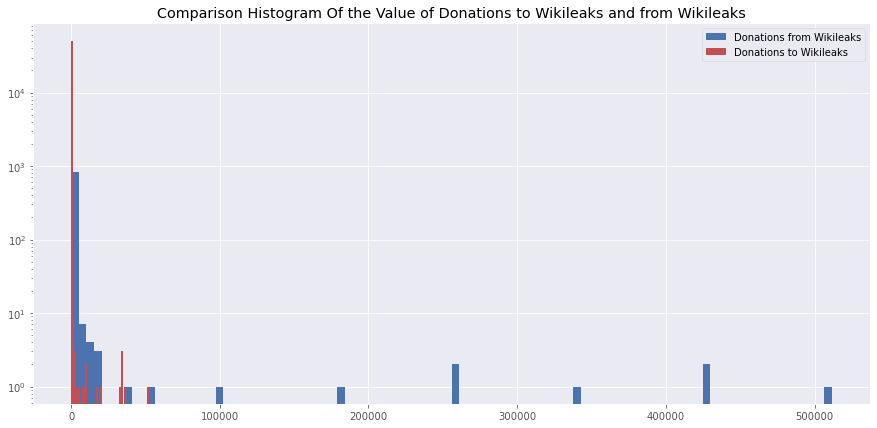

In [150]:
df[df['src'].isin(wikileaks_dsts)]['value_usd'].hist(bins=100, log=True)
df[df['dst'].isin(wikileaks_dsts)]['value_usd'].hist(bins=50, log=True)
plt.title("Comparison Histogram Of the Value of Donations to Wikileaks and from Wikileaks")
plt.legend(['Donations from Wikileaks', 'Donations to Wikileaks'])
plt.show()

# Graph Statistics

In [147]:
print(f"Number of accounts Wikileaks transfers to: {len(df[df['src'].isin(wikileaks_dsts)]['dst_identity'].unique())}")
print(f"Number of transactions made by Wikileaks: {len(df[df['src'].isin(wikileaks_dsts)])}")

Number of accounts Wikileaks transfers to: 35
Number of transactions made by Wikileaks: 849


# Network Visualization

## Donations to Wikileaks

In [160]:
# group source-destination pairs
df_network = df.groupby(['src', 'dst']).sum()['value_usd'].reset_index()
df_network = df_network[df_network['dst'].isin(wikileaks_dsts)]
df_network.replace(
    {
        '1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v': 'wikileaks1', 
        '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4': 'wikileaks2'
    }, 
    inplace=True)

# select top 100 interactions in terms of value
df_network = df_network.sort_values(by='value_usd', ascending=False).iloc[:500]

# create graph of donation network
G = nx.from_pandas_edgelist(df_network, source='src', target='dst', edge_attr=True, create_using=nx.DiGraph())

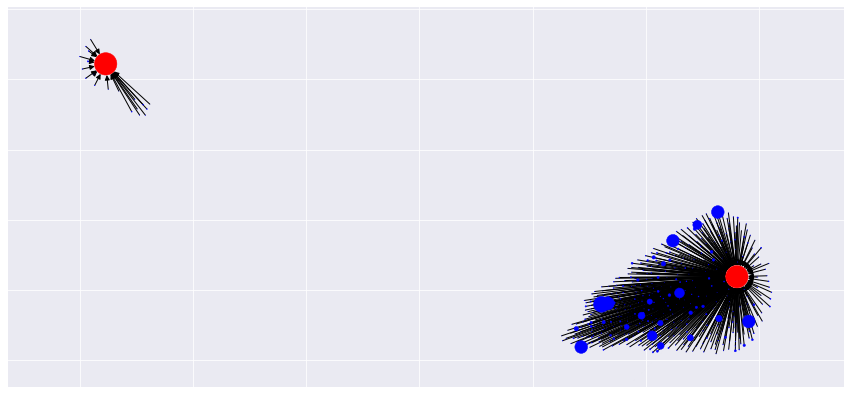

In [162]:
# plot donation network
size_dict = dict(zip(
    df_network['src'], 
    (df_network['value_usd'] - df_network['value_usd'].min())/(df_network['value_usd'].max() - df_network['value_usd'].min()))
    )

colors = []
sizes = []
for node in G:
    if node == 'wikileaks1' or node == 'wikileaks2':
        colors.append("red")
        sizes.append(500)
    else: 
        colors.append("blue")
        sizes.append(250*size_dict[node])

nx.draw_networkx(
    G, 
    arrows=True, 
    with_labels=False, 
    node_size=sizes, 
    node_color=colors,
    label='Graphical representation of WikiLeaks donations.' 
    )